In [1]:
import sys
sys.path.append('/Users/evatakou/noise_est')
import stim
import numpy as np
import pymatching
from pymatching import Matching
import xarray as xr
from circuit_SC_phen import *

In [2]:
from sims.surface_code_bare_ancilla.construct_dem import get_measurement_data,project_data_meas,get_initial_state,surface_code_DEM, get_defects
from sims.surface_code_bare_ancilla.estimation_funcs_surface_code import *
from utilities.general_utils import avg_vi,avg_vivj
from utilities.utils_for_decoding import decode_both_dems_same_data


In [3]:
from sims.surface_code_bare_ancilla.circuit_SC import planar_surface_code_circuit_X_memory as alt_circuit


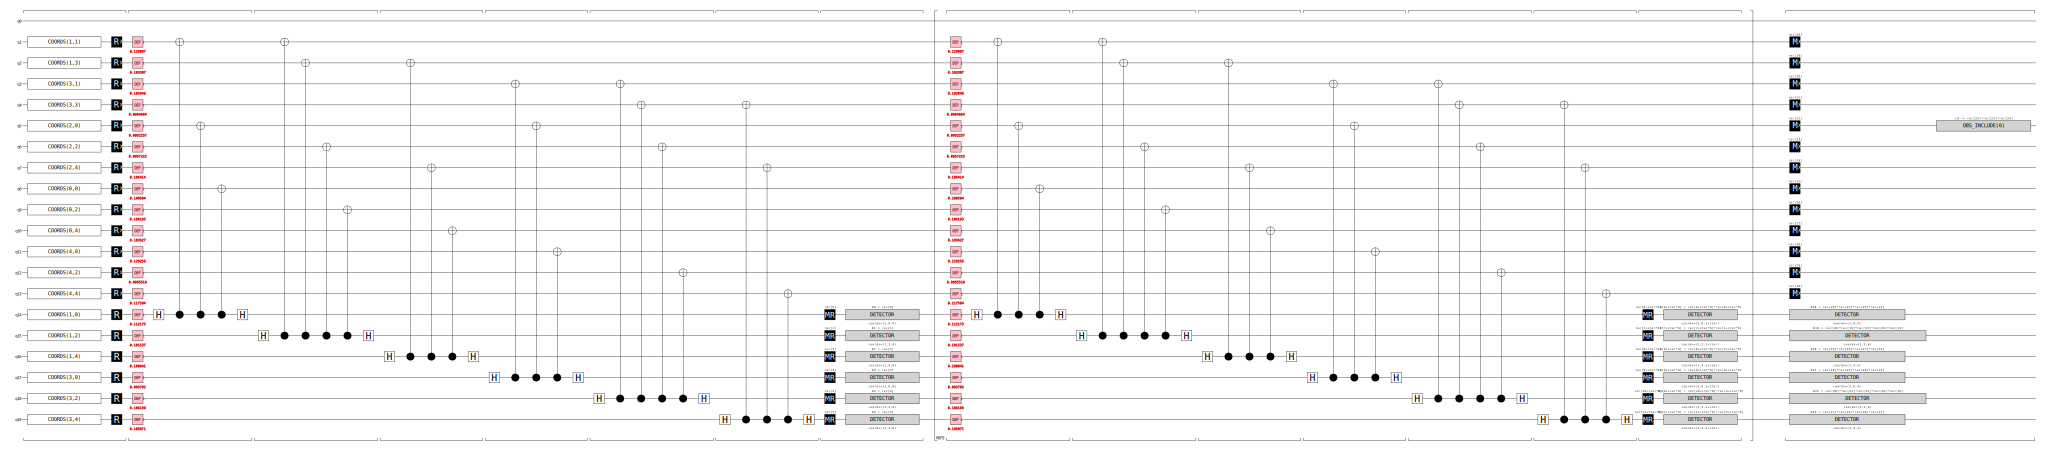

In [4]:
L             = 3
num_rounds    = 3
p_depol_input = 0.1
p_depol_anc   = 0.1
std           = 10**(-2)
circuit       = planar_surface_code_circuit_X_memory(L,num_rounds,p_depol_input,p_depol_anc,std)

circuit.diagram("timeline-svg")

In [ ]:
circuit.detector_error_model(decompose_errors=False)

In [5]:
def get_DEM(distance,num_rounds,num_shots,p_data,p_anc,std):

    num_ancilla   = distance*(distance-1)
    
    circuit       = planar_surface_code_circuit_X_memory(distance,num_rounds,p_data,p_anc,std)

    defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)
    vi_mean                        = avg_vi(defects_matrix)
    vivj_mean                      = avg_vivj(defects_matrix.data)
    
    pij_time        = estimate_time_edge_probs(num_rounds,num_ancilla,vi_mean,vivj_mean)
    pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs(num_rounds,num_ancilla,distance,vi_mean,vivj_mean,pij_time)
    
    my_DEM = surface_code_DEM(pij_bulk,pij_bd,pij_time,circuit.detector_error_model(flatten_loops=True))

    return my_DEM,circuit





In [6]:
def decode_both_dems_same_data(reconstructed_DEM:stim.DetectorErrorModel,circuit:stim.Circuit, detector_error_model: stim.DetectorErrorModel ,num_shots:int):
    '''
    Decode stim's DEM obtained from a circuit and a reconstructed DEM using MWPM, and on the same data.

    Inputs: 
        my_DEM:    Reconstructed detector error model
        circuit:   The true stim circuit (w/ variations on data/ancilla qubits)
        detector_error_model: stim's detector error model for the case of all error rates of data being equal to p, and all error rates of ancilla being equal to q
        num_shots: # of shots to use to decode
    Output:
        num_errors_est:    Total # of logical errors obtained by decoding the reconstructed DEM
        num_errors_stim:   Total # of logical errors obtained by decoding stim's DEM
    '''
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    # detector_error_model = circuit.detector_error_model(flatten_loops=True) 
    matcher              = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors_stim = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors_stim += 1

    #Now do the same for my model.

    matcher     = pymatching.Matching.from_detector_error_model(reconstructed_DEM)
    predictions = matcher.decode_batch(detection_events) #use same detection events

    num_errors_est = 0
    for shot in range(num_shots):
        actual_for_shot    = observable_flips[shot]  #use same obs_flips
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors_est += 1    

    return num_errors_est,num_errors_stim


In [ ]:
import random

np.random.seed(0)

print(np.random.lognormal(0.1,0.08,3))


    
print(np.random.lognormal(0.1,0.08,3))

[1.27267908 1.14112267 1.19518267]
[1.32216621 1.28326119 1.02205752]


In [8]:
p_data                            = 0.0842857142857143
p_anc                             = 0.0842857142857143
std                               = 10**(-2)
num_shots                         = 10**6 #800_000
distance                          = 3
num_rounds                        = 3
my_DEM,circuit_true               = get_DEM(distance,num_rounds,num_shots,p_data,p_anc,std)

# stims_DEM_true = circuit_true.detector_error_model()
# Compare vs the case of stim's dem having equal rates.
circuit2                          = planar_surface_code_circuit_X_memory(distance,num_rounds,p_data,p_anc,std=0)
stims_DEM                         = circuit2.detector_error_model(flatten_loops=True)
num_errors_my_DEM,num_errors_stim = decode_both_dems_same_data(my_DEM,circuit_true,stims_DEM,num_shots)

print("my errors/num_shots:",num_errors_my_DEM/num_shots)
print("stim's errors/num_shots:",num_errors_stim/num_shots)


my errors/num_shots: 0.198766
stim's errors/num_shots: 0.209262


In [ ]:
#Now make a surface plot for various error rates (p,q) and a fixed std for both

def get_logical_error_per_p_and_q(std_in,distance,num_shots,num_vals):

    prange_data    = np.linspace(5*10**(-2),0.13,num_vals)
    prange_ancilla = np.linspace(5*10**(-2),0.13,num_vals)



    num_rounds     = distance     

    all_LE_mine = []
    all_LE_stim = []

    for p in prange_data:
        
        LE_mine = []
        LE_stim = []

        for q in prange_ancilla:

            # if p>=0.08 or q>=0.08:
            #     std_in = 10**(-2)
            # else:
            #     std_in = 10**(-3)

            my_DEM,circuit_true               = get_DEM(distance,num_rounds,num_shots,p,q,std_in)
            circuit2                          = planar_surface_code_circuit_X_memory(distance,num_rounds,p,q,std=0)
            stims_DEM                         = circuit2.detector_error_model(flatten_loops=True)
            num_errors_my_DEM,num_errors_stim = decode_both_dems_same_data(my_DEM,circuit_true,stims_DEM,num_shots)

            print("stim:",num_errors_stim/num_shots,"our_DEM:",num_errors_my_DEM/num_shots)

            LE_mine.append(num_errors_my_DEM/num_shots)
            LE_stim.append(num_errors_stim/num_shots)

        all_LE_mine.append(LE_mine)
        all_LE_stim.append(LE_stim)

    return all_LE_mine,all_LE_stim,prange_data,prange_ancilla

distance                                           = 3
std                                                = 10**(-3)
num_shots                                          = 10**6
num_vals                                           = 15
all_LE_mine,all_LE_stim,prange_data,prange_ancilla = get_logical_error_per_p_and_q(std,distance,num_shots,num_vals)



stim: 0.101456 our_DEM: 0.097708
stim: 0.093956 our_DEM: 0.092458
stim: 0.09432 our_DEM: 0.091134


In [ ]:
with open("stims_for_10_minus_3_and_N_10_6.txt", "w") as file:
    file.write(str(all_LE_stim))

In [ ]:
with open("mine_for_10_minus_3_and_N_10_6.txt", "w") as file:
    file.write(str(all_LE_mine))

In [41]:
improvement_factor = []

 
for k in range(len(prange_data)):
    
    temp1 = all_LE_mine[k]
    temp2 = all_LE_stim[k]
    temp  = []

    for l in range(len(prange_ancilla)):

        # temp.append( abs(temp1[l]-temp2[l])/temp2[l]*100 )  #(xf-x)/x
        temp.append(temp2[l]/temp1[l]) 

        if temp2[l]<temp1[l]:
            print("stim performs better for (p,q) =",(prange_data[k],prange_ancilla[l]))
            print("stim:",temp2[l],"ours:",temp1[l])
            

    improvement_factor.append(temp)


stim performs better for (p,q) = (0.09, 0.11857142857142858)
stim: 0.232107 ours: 0.23266225
stim performs better for (p,q) = (0.09571428571428572, 0.10142857142857142)
stim: 0.24315425 ours: 0.244372
stim performs better for (p,q) = (0.09571428571428572, 0.12428571428571429)
stim: 0.23777025 ours: 0.237825
stim performs better for (p,q) = (0.10142857142857142, 0.13)
stim: 0.262553 ours: 0.264372
stim performs better for (p,q) = (0.11285714285714286, 0.12428571428571429)
stim: 0.2988925 ours: 0.30327675
stim performs better for (p,q) = (0.12428571428571429, 0.13)
stim: 0.327503 ours: 0.32763175


1.1209489558216519
0.9855437319214216


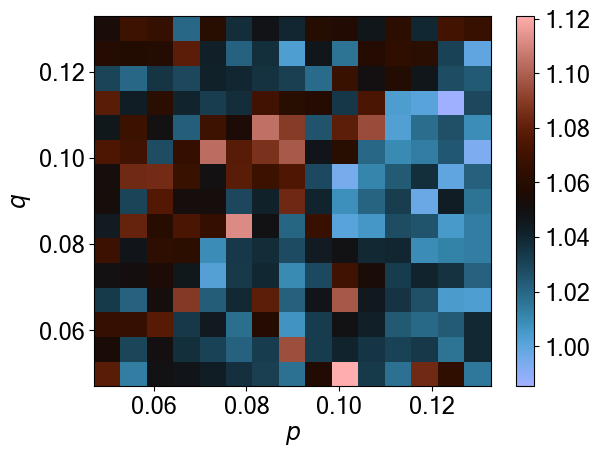

In [44]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy import *
import scipy
import scipy.interpolate
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"   

fig, ax = plt.subplots()


X, Y    = np.meshgrid(prange_data, prange_ancilla)
Z       = np.array(improvement_factor)

# zmin = 0
zmax = abs(Z).max()
print(zmax)
print(abs(Z).min())

plt.pcolormesh(X, Y, Z, cmap=cm.berlin,linewidth=0, antialiased=False,snap=False)#,shading='gouraud'

# plt.contourf(X,Y,Z,levels=200,cmap=cm.Blues)) #
# plt.contourf(X,Y,Z,levels=200,cmap=cm.Blues)

plt.colorbar()
plt.xlabel("$p$")
plt.ylabel("$q$")
# plt.xscale('log')
# plt.yscale('log')
# fig.savefig('ratio_of_thresholds.svg', format='svg', dpi=500,bbox_inches='tight')

fig.savefig("Improvement_factor_d_3_r_3_N_4_10__6_10_minus_2_and_minus_3.pdf",bbox_inches='tight')




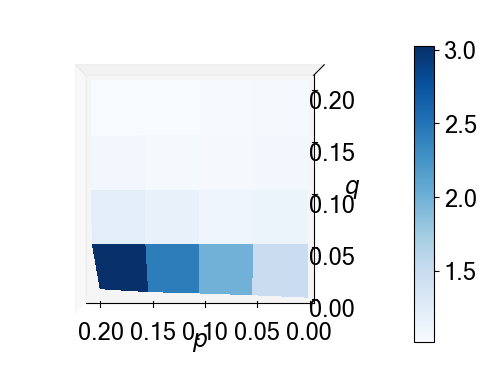

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# fig,ax = plt.subplot()
X, Y    = np.meshgrid(prange_data, prange_ancilla)
Z       = np.array(improvement_factor)

surf = ax.plot_surface(X, Y, Z, cmap=cm.Blues,linewidth=0, antialiased=False)

# ax.contourf(X,Y,np.array(improvement_factor),zdir='z',offset=-1.5,cmap=cm.Blues)

fig.colorbar(surf, shrink=0.8, aspect=15,pad=0.07)

ax.view_init(-90,90,0)
ax.set_zticks([])

ax.set_xlabel("$p$")
ax.set_ylabel("$q$")

ax.grid(False)



# ax.set_xlim3d([0,0.21])
# ax.set_ylim3d([0,0.21])


The rest is w/o using stim

In [2]:
import stim
import numpy as np
from matplotlib import pyplot as plt


from sims.surface_code_bare_ancilla.circuit_SC import *
from sims.surface_code_bare_ancilla.estimation_funcs_surface_code import *
from utilities.utils_for_decoding import decode_both_dems_same_data
from sims.surface_code_bare_ancilla.construct_dem import *


from utilities.general_utils import avg_vi, avg_vivj


In [ ]:
L = 3
HX = surface_code_star_stabs(L)
XL = surface_code_x_logical(L)

In [15]:
np.random.rand()

0.3412708294339585

In [16]:
def num_decoding_failures_noisy_syndromes(H, logicals, p, q, num_shots, repetitions):
    matching = Matching(H, weights=np.log((1-p)/p),
                repetitions=repetitions, timelike_weights=np.log((1-q)/q), faults_matrix=logicals)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0
    for i in range(num_shots):
        noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:,-1]
        syndrome = H@noise_cumulative % 2
        syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
        syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

def num_decoding_failures(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals)
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < error_probability).astype(np.uint8)
        syndrome = H@noise % 2
        predicted_logicals_flipped = matching.decode(syndrome)
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors


def num_decoding_failures_noisy_syndromes_different_probs(H, logicals, pc, qc, std, num_shots, repetitions):
    '''pc: central probability for data qubits
       qc: central probability for anc qubits'''


    matching = Matching(H, weights=np.log((1-pc)/pc),
                repetitions=repetitions, timelike_weights=np.log((1-qc)/qc), faults_matrix=logicals)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0

    for i in range(num_shots):

        noise_new = np.zeros((num_qubits,repetitions)).astype(np.uint8)

        for l in range(num_qubits):
            for rep in range(repetitions):
                noise_new[l,rep] = np.random.rand()<np.random.normal(loc=pc,scale=std)

        # noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)

        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:,-1]
        syndrome = H@noise_cumulative % 2


        syndrome_error = np.zeros((num_stabilisers,repetitions)).astype(np.uint8)
        for l in range(num_stabilisers):
            for rep in range(repetitions):
                syndrome_error[l,rep] = np.random.rand()<np.random.normal(loc=qc,scale=std)

        
        
        syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors


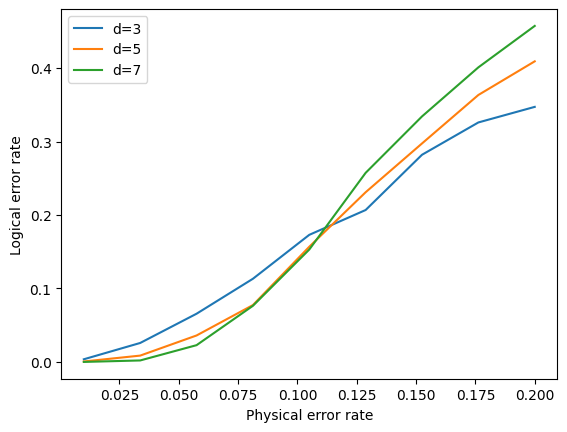

In [10]:
num_shots=5000

d = range(3,9,2)

p=np.linspace(0.01,0.2,9)

log_errors_all_L=[]
for L in d:
    
    #H = repetition_code(L)
    H        = surface_code_star_stabs(L)
    logicals= surface_code_z_logical(L)
    #logicals=repetition_x_logical(L)
    log_errors=[]
    
    for k in p:

        num_errors=num_decoding_failures(H, logicals, k,  num_shots)

        log_errors.append(num_errors/num_shots)
    
    log_errors_all_L.append(np.array(log_errors))
       
plt.figure()
for m in range(0,len(d)):
    #std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
     plt.plot(p, log_errors_all_L[m], label="d=" + str(d[m]))
    #plt.errorbar(p, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

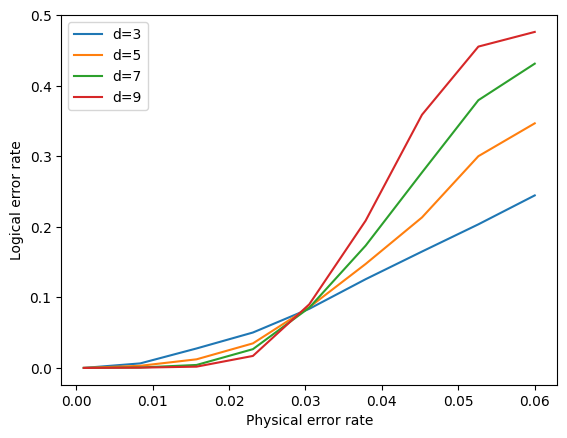

In [ ]:
num_shots=5000

d = range(3,11,2)

prange=np.linspace(0.001,0.06,9)

log_errors_all_L=[]
for L in d:
    
    #H = repetition_code(L)
    H=surface_code_star_stabs(L)
    logicals= surface_code_z_logical(L)
    #logicals=repetition_x_logical(L)
    log_errors=[]
    repetitions = L
    
    for p in prange:
        
        q          = p
        num_errors = num_decoding_failures_noisy_syndromes(H, logicals, p, q, num_shots, repetitions)
        log_errors.append(num_errors/num_shots)
    
    log_errors_all_L.append(np.array(log_errors))
       
plt.figure()
for m in range(0,len(d)):
    # std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
     plt.plot(prange, log_errors_all_L[m], label="d=" + str(d[m]))
    #plt.errorbar(p, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

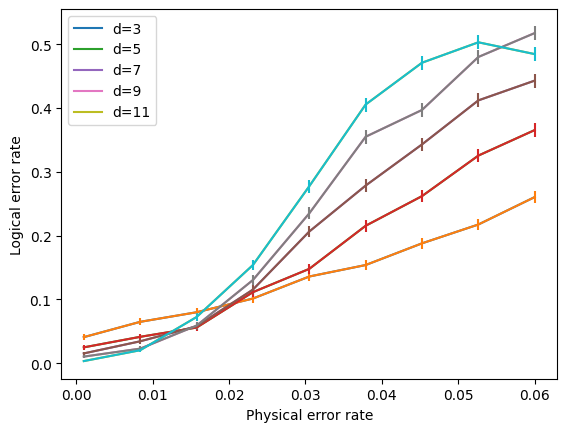

In [ ]:
num_shots = 2000
std       = 5*10**(-2)


d = range(3,13,2)

prange=np.linspace(0.001,0.06,9)

log_errors_all_L=[]
for L in d:
    
    H=surface_code_star_stabs(L)
    logicals= surface_code_z_logical(L)
    log_errors=[]
    repetitions = L
    
    for p in prange:
        
        q          = p
        num_errors = num_decoding_failures_noisy_syndromes_different_probs(H, logicals, p, q, std, num_shots, repetitions)
        log_errors.append(num_errors/num_shots)
    
    log_errors_all_L.append(np.array(log_errors))
       
plt.figure()
for m in range(0,len(d)):
    std_err = (log_errors_all_L[m]*(1-log_errors_all_L[m])/num_shots)**0.5
    plt.plot(prange, log_errors_all_L[m], label="d=" + str(d[m]))
    # plt.errorbar(prange, log_errors_all_L[m], yerr=std_err) #label="L={}".format(L)
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);